In [2]:
!pip install tflearn
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
import tflearn.datasets.oxflower17 as oxflower17
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
X, y = oxflower17.load_data()

Starting to parse images...
Parsing Done!


In [4]:
X.shape, y.shape

((1360, 224, 224, 3), (1360,))

In [5]:
print("Total labels: {}".format(len(np.unique(y))))
print("Labels: {}".format(y))

Total labels: 17
Labels: [ 1  2 13 ... 12 14 15]


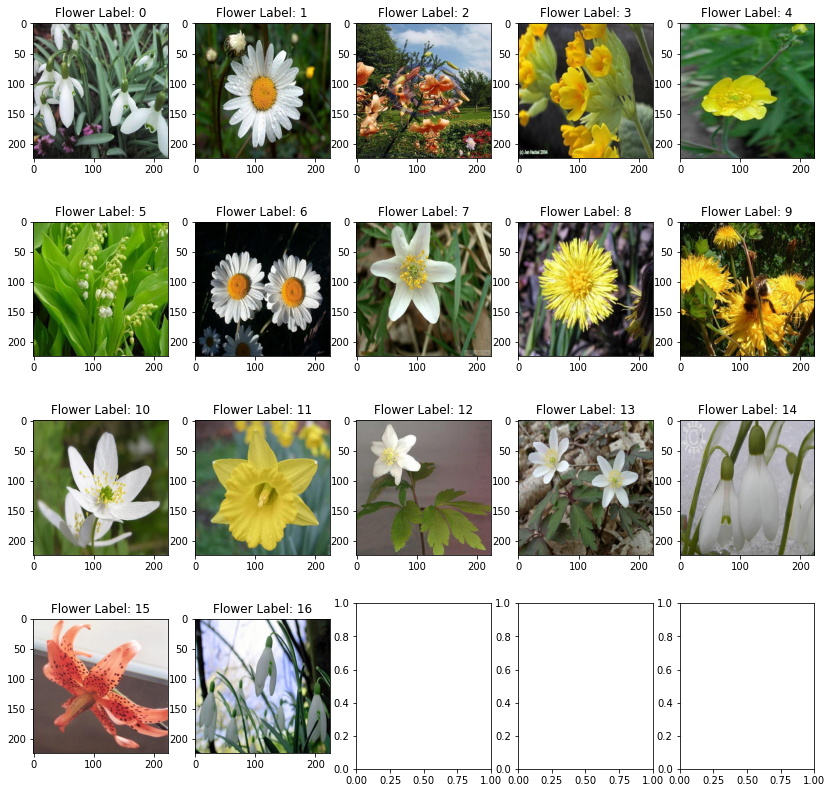

In [6]:
cols = 5
rows = rows = int(np.ceil(len(np.unique(y))/cols))
fix, ax = plt.subplots(rows, cols, figsize = (14, 14))

for i in np.unique(y):
    col = i%5
    row = int(i/5)
    
    ax[row][col].imshow(X[i])
    ax[row][col].set_title(f'Flower Label: {i}')
plt.show()

In [7]:
X_train, X_val, y_train, y_val = train_test_split(np.array(X), y, test_size = 0.3, random_state = 16)

In [8]:
print(f"Shapes of Train and Validation sets are: {X_train.shape},{X_val.shape}")

Shapes of Train and Validation sets are: (952, 224, 224, 3),(408, 224, 224, 3)


In [9]:
y_train = to_categorical(y_train, num_classes = 17)
y_val = to_categorical(y_val, num_classes = 17)

In [10]:
print(f"Shapes of Train and Validation sets of Target are: {y_train.shape},{y_val.shape}")

Shapes of Train and Validation sets of Target are: (952, 17),(408, 17)


In [11]:
img_rows, img_cols = X.shape[1], X.shape[2]

vgg16 = VGG16(weights = 'imagenet',
                      include_top = False,
                      input_shape = (img_rows, img_cols, 3))

for layer in vgg16.layers:
    layer.trainable = False
    
for (i, layer) in enumerate(vgg16.layers):
    print(str(i + 1) + " " + layer.__class__.__name__, layer.trainable)

58900480/58889256 [==============================] - 0s 0us/step


2022-03-30 13:26:04.165757: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 13:26:04.259007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 13:26:04.259812: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 13:26:04.261911: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

1 InputLayer False
2 Conv2D False
3 Conv2D False
4 MaxPooling2D False
5 Conv2D False
6 Conv2D False
7 MaxPooling2D False
8 Conv2D False
9 Conv2D False
10 Conv2D False
11 MaxPooling2D False
12 Conv2D False
13 Conv2D False
14 Conv2D False
15 MaxPooling2D False
16 Conv2D False
17 Conv2D False
18 Conv2D False
19 MaxPooling2D False


In [12]:
def addTopModel(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Flatten(name = 'flatten')(top_model)
    top_model = Dense(256, activation = 'relu')(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(num_classes, activation = 'softmax')(top_model)
    
    return top_model

In [13]:
num_classes = len(np.unique(y))

FC_Head = addTopModel(vgg16, num_classes)

model = Model(inputs = vgg16.input, outputs = FC_Head)

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
model.compile(optimizer = optimizers.Adam(lr = 0.0001),
              loss = BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'])

history = model.fit(X_train, y_train, epochs = 20, validation_data = (X_val, y_val))

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/opt/conda/lib/python3.7/site-packages/keras/backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


Train on 952 samples, validate on 408 samples
Epoch 1/20


2022-03-30 13:26:08.247663: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


952/952 [==============================] - ETA: 0s - loss: 0.5596 - acc: 0.9412

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


952/952 [==============================] - 14s 15ms/sample - loss: 0.5596 - acc: 0.9412 - val_loss: 0.4379 - val_acc: 0.9412
Epoch 2/20
952/952 [==============================] - 3s 3ms/sample - loss: 0.3857 - acc: 0.9412 - val_loss: 0.3112 - val_acc: 0.9412
Epoch 3/20
952/952 [==============================] - 3s 3ms/sample - loss: 0.2911 - acc: 0.9412 - val_loss: 0.2537 - val_acc: 0.9412
Epoch 4/20
952/952 [==============================] - 3s 3ms/sample - loss: 0.2541 - acc: 0.9412 - val_loss: 0.2322 - val_acc: 0.9412
Epoch 5/20
952/952 [==============================] - 3s 3ms/sample - loss: 0.2385 - acc: 0.9412 - val_loss: 0.2235 - val_acc: 0.9412
Epoch 6/20
952/952 [==============================] - 3s 3ms/sample - loss: 0.2322 - acc: 0.9412 - val_loss: 0.2192 - val_acc: 0.9412
Epoch 7/20
952/952 [==============================] - 3s 3ms/sample - loss: 0.2270 - acc: 0.9412 - val_loss: 0.2161 - val_acc: 0.9412
Epoch 8/20
952/952 [==============================] - 3s 3ms/sample - l

In [15]:
bike_horse_path = "../input/bike-horse-dataset"
train_datagen = ImageDataGenerator(rescale = 1./255)
train = train_datagen.flow_from_directory(bike_horse_path, target_size = (224, 224), class_mode = 'categorical')

Found 179 images belonging to 2 classes.


In [16]:
X_train2, X_val2, y_train2, y_val2 = train_test_split(np.array(train[0][0]), np.array(train[0][1]), test_size = 0.3, random_state = 16)

In [17]:
print(f"Shapes of Train and Validation sets are: {X_train2.shape},{X_val2.shape}")
print(f"Shapes of Train and Validation sets of Target are: {y_train2.shape},{y_val2.shape}")

Shapes of Train and Validation sets are: (22, 224, 224, 3),(10, 224, 224, 3)
Shapes of Train and Validation sets of Target are: (22, 2),(10, 2)


In [18]:
img_rows2, img_cols2 = 224, 224

vgg16_2 = VGG16(weights = 'imagenet',
                      include_top = False,
                      input_shape = (img_rows, img_cols, 3))

for layer in vgg16_2.layers:
    layer.trainable = False
    
for (i, layer) in enumerate(vgg16_2.layers):
    print(str(i + 1) + " " + layer.__class__.__name__, layer.trainable)

1 InputLayer False
2 Conv2D False
3 Conv2D False
4 MaxPooling2D False
5 Conv2D False
6 Conv2D False
7 MaxPooling2D False
8 Conv2D False
9 Conv2D False
10 Conv2D False
11 MaxPooling2D False
12 Conv2D False
13 Conv2D False
14 Conv2D False
15 MaxPooling2D False
16 Conv2D False
17 Conv2D False
18 Conv2D False
19 MaxPooling2D False


In [19]:
num_classes2 = 2

FC_Head = addTopModel(vgg16_2, num_classes2)

model2 = Model(inputs = vgg16_2.input, outputs = FC_Head)

print(model2.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [22]:
model2.compile(optimizer = optimizers.Adam(lr = 0.0001),
              loss = BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'])

history = model2.fit(X_train2, y_train2, epochs = 20, validation_data = (X_val2, y_val2))

Train on 22 samples, validate on 10 samples
Epoch 1/20
22/22 [==============================] - 0s 13ms/sample - loss: 0.4423 - acc: 0.7727 - val_loss: 0.4900 - val_acc: 0.8000
Epoch 2/20
22/22 [==============================] - 0s 4ms/sample - loss: 0.4454 - acc: 0.7727 - val_loss: 0.4833 - val_acc: 0.8000
Epoch 3/20
22/22 [==============================] - 0s 4ms/sample - loss: 0.4449 - acc: 0.7727 - val_loss: 0.4773 - val_acc: 0.8000
Epoch 4/20
22/22 [==============================] - 0s 4ms/sample - loss: 0.4362 - acc: 0.7273 - val_loss: 0.4711 - val_acc: 0.8000
Epoch 5/20
22/22 [==============================] - 0s 4ms/sample - loss: 0.4315 - acc: 0.7727 - val_loss: 0.4649 - val_acc: 0.8000
Epoch 6/20
22/22 [==============================] - 0s 4ms/sample - loss: 0.4008 - acc: 0.8636 - val_loss: 0.4591 - val_acc: 0.8000
Epoch 7/20
22/22 [==============================] - 0s 4ms/sample - loss: 0.4428 - acc: 0.8182 - val_loss: 0.4534 - val_acc: 0.8000
Epoch 8/20
22/22 [=============